In [1]:
import matplotlib.pyplot as plt
import numpy as np

import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import cnn

In [2]:
transform = transforms.Compose( # composing several transforms together
    [transforms.ToTensor(), # to tensor object
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]) # mean = 0.5, std = 0.5

# set batch_size
batch_size = 4

# set number of workers
num_workers = 2

# load train data
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=num_workers)

# load test data
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=num_workers)

# put 10 classes into a set
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100%|██████████| 170M/170M [01:54<00:00, 1.49MB/s] 


Extracting ./data\cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [23]:
len(trainset)

50000

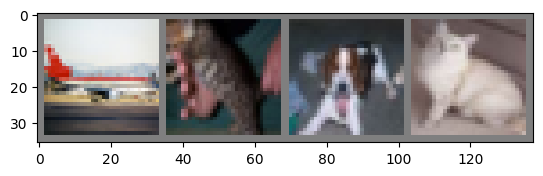

plane cat dog cat


In [4]:
def imshow(img):
  ''' function to show image '''
  img = img / 2 + 0.5 # unnormalize
  npimg = img.numpy() # convert to numpy objects
  plt.imshow(np.transpose(npimg, (1, 2, 0)))
  plt.show()

# get random training images with iter function
dataiter = iter(trainloader)
images, labels = next(dataiter)

# call function on our images
imshow(torchvision.utils.make_grid(images))

# print the class of the image
print(' '.join('%s' % classes[labels[j]] for j in range(batch_size)))

In [11]:
device = torch.device(f'cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [14]:
net = cnn.Net()
print(net)
net.to(device)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [15]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [17]:
start = torch.cuda.Event(enable_timing=True)
end = torch.cuda.Event(enable_timing=True)

start.record()

for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

# whatever you are timing goes here
end.record()

# Waits for everything to finish running
torch.cuda.synchronize()

print('Finished Training')
print(start.elapsed_time(end))  # milliseconds

[1,  2000] loss: 2.243
[1,  4000] loss: 1.922
[1,  6000] loss: 1.694
[1,  8000] loss: 1.583
[1, 10000] loss: 1.514
[1, 12000] loss: 1.468
[2,  2000] loss: 1.406
[2,  4000] loss: 1.384
[2,  6000] loss: 1.360
[2,  8000] loss: 1.336
[2, 10000] loss: 1.314
[2, 12000] loss: 1.266
Finished Training
91692.703125


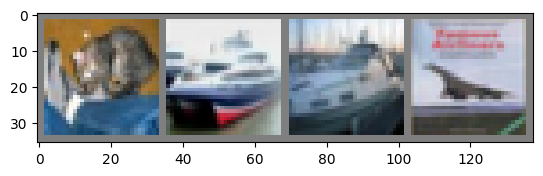

GroundTruth:  cat ship ship plane


In [18]:
dataiter = iter(testloader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%s' % classes[labels[j]] for j in range(4)))

In [9]:
outputs = net(images)
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%s' % classes[predicted[j]] for j in range(4)))

Predicted:  cat ship car plane


In [21]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 55 %


In [36]:
def get_regularized_curvature_for_batch(batch_data, batch_labels, h=1e-3, niter=10, temp=1):
    num_samples = batch_data.shape[0]
    net.eval()
    regr = torch.zeros(num_samples)
    eigs = torch.zeros(num_samples)
    for _ in range(niter):
        v = torch.randint_like(batch_data, high=2).cuda()
        # Generate Rademacher random variables
        for v_i in v:
            v_i[v_i == 0] = -1

        v = h * (v + 1e-7)

        batch_data.requires_grad_()
        outputs_pos = net(batch_data + v)
        outputs_orig = net(batch_data)
        loss_pos = criterion(outputs_pos / temp, batch_labels)
        loss_orig = criterion(outputs_orig / temp, batch_labels)
        grad_diff = torch.autograd.grad((loss_pos-loss_orig), batch_data )[0]

        regr += grad_diff.reshape(grad_diff.size(0), -1).norm(dim=1).cpu().detach()
        eigs += torch.diag(torch.matmul(v.reshape(num_samples,-1), grad_diff.reshape(num_samples,-1).T)).cpu().detach()
        net.zero_grad()
        if batch_data.grad is not None:
            batch_data.grad.zero_()

    eig_estimate = eigs / niter
    curv_estimate = regr / niter
    return eig_estimate, curv_estimate

In [32]:
orderedtrainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                                 shuffle=False, num_workers=num_workers)

In [52]:
scores = torch.zeros(len(trainset))
eig_score = torch.zeros_like(scores)
labels = torch.zeros_like(scores, dtype=torch.long)
net.eval()
total = 0

for i, data in enumerate(orderedtrainloader, 0):
    # get the inputs; data is a list of [inputs, labels]
    inputs, targets = data
    inputs, targets = inputs.to(device), targets.to(device)

    start_idx = total
    stop_idx = total + len(targets)
    idxs = [j for j in range(start_idx, stop_idx)]
    total = stop_idx

    inputs.requires_grad = True
    net.zero_grad()

    eig_estimate, curv_estimate = get_regularized_curvature_for_batch(inputs, targets)
    scores[idxs] = curv_estimate.detach().clone().cpu()
    eig_score[idxs] = eig_estimate.detach().clone().cpu()
    labels[idxs] = targets.cpu().detach()

In [53]:
torch.save(scores, 'scores.pt')
torch.save(eig_score, 'eig_score.pt')
torch.save(labels, 'labels.pt')

(array([5000., 5000., 5000., 5000., 5000., 5000., 5000., 5000., 5000.,
        5000.]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]),
 <BarContainer object of 10 artists>)

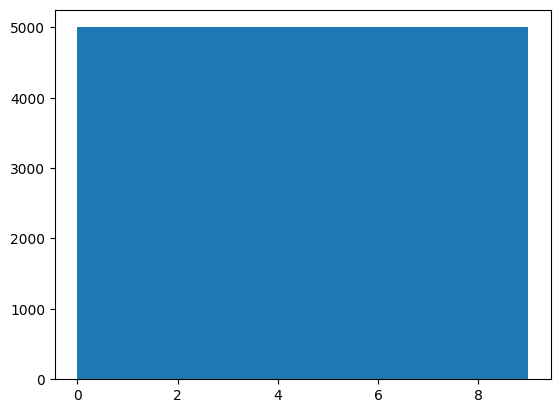

In [54]:
plt.hist(labels)

(array([3.5390e+04, 1.1238e+04, 2.5450e+03, 5.6300e+02, 1.7400e+02,
        6.3000e+01, 1.6000e+01, 6.0000e+00, 1.0000e+00, 4.0000e+00]),
 array([1.98755401e-06, 1.68191437e-02, 3.36363018e-02, 5.04534580e-02,
        6.72706142e-02, 8.40877667e-02, 1.00904927e-01, 1.17722087e-01,
        1.34539232e-01, 1.51356384e-01, 1.68173537e-01]),
 <BarContainer object of 10 artists>)

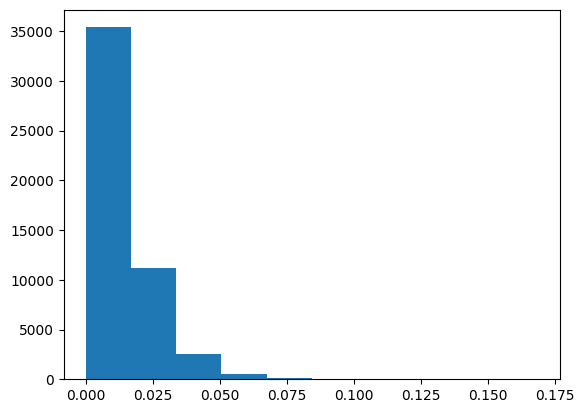

In [56]:
plt.hist(scores)

In [58]:
values, indices = torch.topk(scores, 20)

In [77]:
top_images = [trainset[k][0].cpu() for k in indices]
top_labels = [trainset[k][1] for k in indices]

In [74]:
trainset[0][0]

tensor([[[-0.5373, -0.6627, -0.6078,  ...,  0.2392,  0.1922,  0.1608],
         [-0.8745, -1.0000, -0.8588,  ..., -0.0353, -0.0667, -0.0431],
         [-0.8039, -0.8745, -0.6157,  ..., -0.0745, -0.0588, -0.1451],
         ...,
         [ 0.6314,  0.5765,  0.5529,  ...,  0.2549, -0.5608, -0.5843],
         [ 0.4118,  0.3569,  0.4588,  ...,  0.4431, -0.2392, -0.3490],
         [ 0.3882,  0.3176,  0.4039,  ...,  0.6941,  0.1843, -0.0353]],

        [[-0.5137, -0.6392, -0.6235,  ...,  0.0353, -0.0196, -0.0275],
         [-0.8431, -1.0000, -0.9373,  ..., -0.3098, -0.3490, -0.3176],
         [-0.8118, -0.9451, -0.7882,  ..., -0.3412, -0.3412, -0.4275],
         ...,
         [ 0.3333,  0.2000,  0.2627,  ...,  0.0431, -0.7569, -0.7333],
         [ 0.0902, -0.0353,  0.1294,  ...,  0.1608, -0.5137, -0.5843],
         [ 0.1294,  0.0118,  0.1137,  ...,  0.4431, -0.0745, -0.2784]],

        [[-0.5059, -0.6471, -0.6627,  ..., -0.1529, -0.2000, -0.1922],
         [-0.8431, -1.0000, -1.0000,  ..., -0

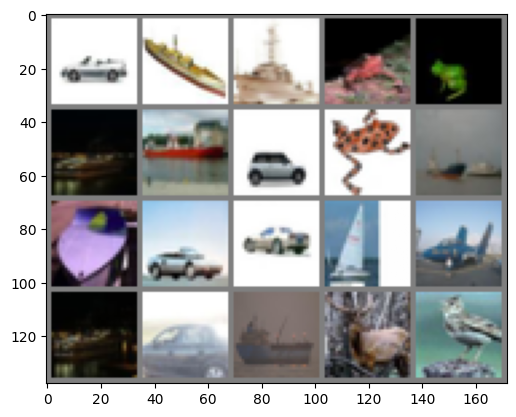

GroundTruth:  car ship ship frog frog ship ship car frog ship ship car car ship plane ship car ship deer bird


In [78]:
imshow(torchvision.utils.make_grid(top_images, nrow=5))
print('GroundTruth: ', ' '.join('%s' % classes[top_labels[j]] for j in range(len(top_labels))))

In [79]:
min_values, min_indices = torch.topk(scores, 20, largest=False)

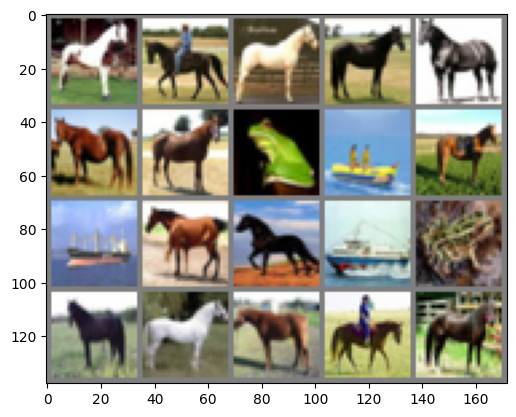

GroundTruth:  horse horse horse horse horse horse horse frog ship horse ship horse horse ship frog horse horse horse horse horse


In [81]:
bot_images = [trainset[k][0].cpu() for k in min_indices]
bot_labels = [trainset[k][1] for k in min_indices]

imshow(torchvision.utils.make_grid(bot_images, nrow=5))
print('GroundTruth: ', ' '.join('%s' % classes[bot_labels[j]] for j in range(len(bot_labels))))

In [91]:
max_values, max_indices = torch.topk(scores, 1000)
min_values, min_indices = torch.topk(scores, 1000, largest=False)

In [94]:
car_max_indices = []
for idx in max_indices:
    if trainset[idx][1] == 1:
        car_max_indices.append(idx)
        if len(car_max_indices) == 20:
            break
car_min_indices = []
for idx in min_indices:
    if trainset[idx][1] == 1:
        car_min_indices.append(idx)
        if len(car_min_indices) == 20:
            break

In [96]:
car_min_indices

[tensor(31619),
 tensor(26080),
 tensor(30752),
 tensor(30362),
 tensor(18181),
 tensor(25926),
 tensor(31352),
 tensor(45099),
 tensor(3779),
 tensor(136),
 tensor(29270),
 tensor(5666),
 tensor(45013),
 tensor(18671),
 tensor(65),
 tensor(3062),
 tensor(14302),
 tensor(13755),
 tensor(15496),
 tensor(13908)]

In [97]:
top_car_images = [trainset[k][0].cpu() for k in car_max_indices]
bot_car_images = [trainset[k][0].cpu() for k in car_min_indices]

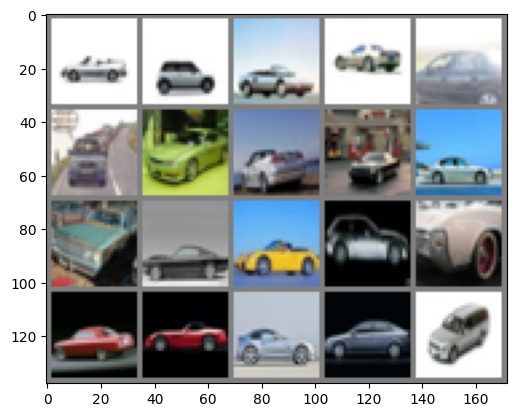

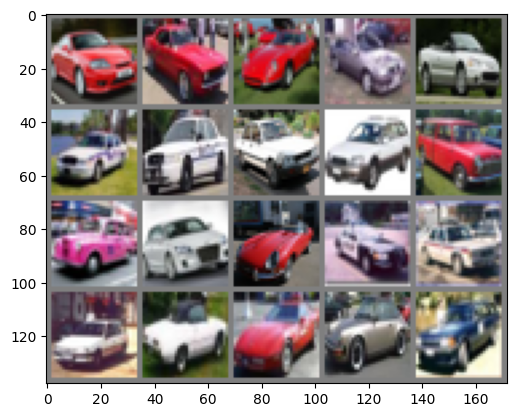

In [99]:
imshow(torchvision.utils.make_grid(top_car_images, nrow=5))
imshow(torchvision.utils.make_grid(bot_car_images, nrow=5))